In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
torch.set_default_dtype(torch.double)

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
def train(dataloader, model, loss_fn, optimizer, print_frequency=0):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_frequency > 0 and batch % print_frequency == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [5]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [6]:
class LogActivation(nn.Module):
    def forward(self, x):
        return torch.log(x)
        return torch.log(torch.maximum(x, torch.tensor(1e-10)))
    
class ExpActivation(nn.Module):
    def forward(self, x):
        return torch.exp(x)

# Define model
class PolynomialNN(nn.Module):
    def __init__(self, n_monomials=1):
        super(PolynomialNN, self).__init__()
        self.dense_stack = nn.Sequential(
            LogActivation(),
            nn.Linear(1, n_monomials, bias=False),
            ExpActivation(),
            nn.Linear(n_monomials, 1)
        )
        
    def forward(self, x):
        x = self.dense_stack(x)
        return x

In [7]:
# Define Data
class DatasetFromFunction(Dataset):
    def __init__(self, sample_fn, target_fn, size, noise_fn = None, positive_only=False):
        self.x = sample_fn(size)[:, None]
        if positive_only:
            self.x = torch.abs(self.x)
        self.y = target_fn(self.x)
        if noise_fn:
            self.y += noise_fn(size)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [8]:
def truncated_normal(n, min_val, rng):
    normal_sample = lambda: torch.normal(0, 1, (n,), generator=rng)
    x = normal_sample()
    while (x < min_val).any():
        x_new = normal_sample()
        x[x < min_val] = x_new[x < min_val]
    return x

# Convergence Experiments

Generate the training and test set

Text(0.5, 1.0, 'Training Set')

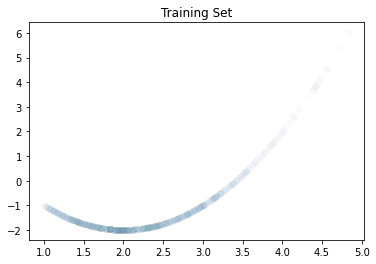

In [9]:
rng = torch.Generator(device="cpu")
rng.manual_seed(0)
# sample_fn = lambda n: torch.normal(0, 1, (n,), generator=rng)
sample_fn = lambda n: 2 + truncated_normal(n, -1, rng)
# target_fn = lambda x: 2*x**3 - 15*x**2 + 36*x - 25
target_fn = lambda x: x**2 - 4*x + 2
training_data = DatasetFromFunction(sample_fn, target_fn, 1000, positive_only = True)
test_data = DatasetFromFunction(sample_fn, target_fn, 100, positive_only = True)
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

plt.scatter(training_data[:][0], training_data[:][1], alpha=0.01)
plt.title("Training Set")

Initialize the model

In [10]:
torch.manual_seed(68225)
model = PolynomialNN(2).to(device)
print(model)

PolynomialNN(
  (dense_stack): Sequential(
    (0): LogActivation()
    (1): Linear(in_features=1, out_features=2, bias=False)
    (2): ExpActivation()
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
)


Train the model

In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8, nesterov=True)

In [12]:
epochs = 1000
exponent_path = [model.dense_stack[1].weight.cpu().detach().numpy()]
for t in tqdm(range(epochs)):
    train(train_dataloader, model, loss_fn, optimizer)
    exponent_path.append(model.dense_stack[1].weight.cpu().detach().numpy())
test(test_dataloader, model, loss_fn)
print("Done!")

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.04s/it]

Test Error: Avg loss: 0.898874 

Done!


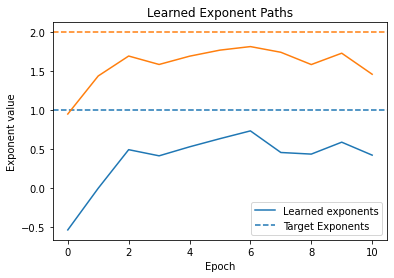

In [13]:
paths = np.stack(exponent_path).squeeze()
ind = np.argsort(paths[-1])
paths = paths[:, ind]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i in range(paths.shape[1]):
    label = "Learned exponents" if i == 0 else None
    plt.plot(paths[:, i], label=label, c=colors[i])
    label = "Target Exponents" if i == 0 else None
    plt.axhline(i+1, label=label, c=colors[i], ls="--")
    
if paths.min() < -10:
    plt.yscale('symlog')
    plt.ylim(top = 1.5*max(3, paths.max()))
        
plt.title("Learned Exponent Paths")
plt.xlabel("Epoch")
plt.ylabel("Exponent value")
plt.legend()

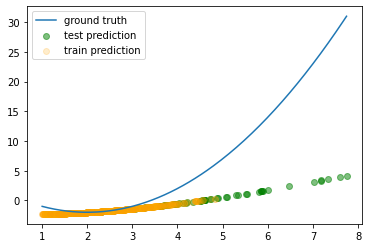

In [14]:
train_x = training_data[:][0]
test_x = test_data[:][0] * 2 - 1
# test_x = torch.normal(0, 3, (100,), generator=rng)[:, None].abs()
x = torch.cat((train_x, test_x))
x = torch.from_numpy(np.linspace(x.min(), x.max(), 200))

model.eval()
model.to('cpu')
plt.plot(x, target_fn(x), label="ground truth")
plt.scatter(test_x, model(test_x).detach(), c="green", alpha=0.5, label="test prediction")
plt.scatter(train_x, model(train_x).detach(), c="orange", alpha=0.2, label="train prediction")
model.to(device)
plt.legend()

In [15]:
model.dense_stack[1].weight, model.dense_stack[1].bias

(Parameter containing:
 tensor([[1.4618],
         [0.4254]], device='cuda:0', requires_grad=True),
 None)

In [16]:
model.dense_stack[-1].weight, model.dense_stack[-1].bias

(Parameter containing:
 tensor([[ 0.4627, -1.6520]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-1.0875], device='cuda:0', requires_grad=True))